<a href="https://colab.research.google.com/github/paolodc5/ANN_H1_wbc_classification/blob/main/Multi_fullslice_TESTING_Paolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SEED = 442

import os

import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl


from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from google.colab import drive

import cv2

# Set the seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)



drive.mount('/gdrive')
%cd /gdrive/My Drive/Applied AI in biomedicine/Group project/Test_fullslice

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1oUZp9UH-_VPBCgQAfQTLtCF-qDnPMJ2P/Group project/Test_fullslice


## Utility functions

In [2]:
def visualize_images(images, labels, n_images=5, indices=None, cmap='gray'):
    """Visualizes a random set of images from a training set with their labels.

    Args:
        images (np.ndarray): Array of images (n_samples, x, y).
        labels (np.ndarray): Array of corresponding labels.
        n_images (int, optional): Number of images to visualize. Defaults to 5.
    """

    n_samples = images.shape[0]
    if not indices:
        random_indices = np.random.choice(n_samples, size=min(n_images, n_samples), replace=False)
    else:
        random_indices = indices

    # Just some checks
    assert len(random_indices) == len(set(random_indices)), "Random indices must be unique"
    assert len(random_indices) == n_images, "Number of random indices must match n_images"


    plt.figure(figsize=(10, 5))
    for i, index in enumerate(random_indices):
        plt.subplot(1, min(n_images, n_samples), i + 1)
        plt.imshow(images[index], cmap=cmap)
        plt.title(f"Label: {labels[index]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:

def visualize_histograms(image1, image2, lim_x=True):
    """
    Visualizes the histograms of two images side-by-side using seaborn.

    Args:
        image1: The first image as a NumPy array.
        image2: The second image as a NumPy array.
    Returns:
        None
    """
    threshold = [-1300,3000]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Flatten the images for histogram calculation
    image1_flat = image1.flatten()
    image2_flat = image2.flatten()

    # Plot the histograms
    sns.histplot(image1_flat, kde=False, ax=axes[0])
    axes[0].set_xlabel('Pixel Intensity')
    axes[0].set_ylabel('Frequency')
    if lim_x:
      axes[0].set_xlim(threshold[0],threshold[1])

    sns.histplot(image2_flat, kde=False, ax=axes[1])
    axes[1].set_xlabel('Pixel Intensity')
    axes[1].set_ylabel('Frequency')


    plt.tight_layout()
    plt.show()




## Load Data and prepare for training


In [4]:
cd = os.getcwd()
print(cd)
os.listdir(cd)

/gdrive/.shortcut-targets-by-id/1oUZp9UH-_VPBCgQAfQTLtCF-qDnPMJ2P/Group project/Test_fullslice


['fullslice_images.npy',
 'fullslice_image_names.npy',
 'fullslice_images_preprocessed.npy',
 'binary_test_predictions.npy']

In [5]:
# train = np.load('fullslice_train.npy', allow_pickle=True).item()
# val = np.load('fullslice_val.npy',allow_pickle=True).item()

X_test = np.load('fullslice_images_preprocessed.npy', allow_pickle=True)
filenames = np.load('fullslice_image_names.npy', allow_pickle=True)

In [6]:
# X_train = train['images']
# y_train = train['labels']
# X_val = val['images']
# y_val = val['labels']


# print('Shape of training images: ', X_train.shape)
# print('Shape of training labels: ', y_train.shape)
# print('Shape of validation images: ', X_val.shape)
# print('Shape of validation labels: ', y_val.shape)

# print('primo sample y_train: ', y_train[0])
# print('primo sample y_train: ', y_val[0])

# del train, val

## Class weights

## Create dataset object

In [7]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = (tf.data.Dataset.from_tensor_slices(X_test)
                 .batch(BATCH_SIZE)
                 .prefetch(buffer_size=AUTOTUNE))



In [8]:
## Normalization
data_min = -1300
data_max = 1000

def normalize(image, min=data_min, max=data_max):
    image = tf.cast(image, tf.float32)
    image = (image - data_min) / (data_max - data_min) * 255.0
    image = tf.cast(image, tf.uint8)
    return image


train_dataset = train_dataset.map(normalize,num_parallel_calls=AUTOTUNE)


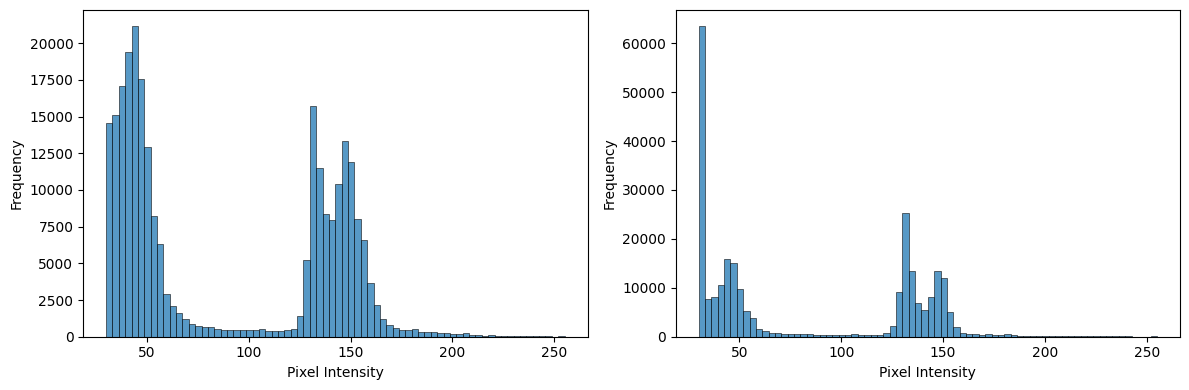

In [9]:
for images in train_dataset.take(1):  # Take one batch from the dataset
    visualize_histograms(images.numpy()[1], images.numpy()[2], lim_x=False)

In [10]:
# Adding a dimension
def add_dimension(image):
    image = tf.expand_dims(image, axis=-1)
    # label = tf.expand_dims(label, axis=-1)
    return image

train_dataset = train_dataset.map(add_dimension, num_parallel_calls=AUTOTUNE)


In [11]:
# Check shapes after transformations
for batch_images in train_dataset.take(1):
    print("Shape of training images batch:", batch_images.shape)
    # print("Shape of training labels batch:", batch_labels.shape)



Shape of training images batch: (32, 512, 512, 1)


## Image Preprocessing

### Image cropping (NOT USED!)

In [12]:
    def torax_crop(data, filter_size=15, kernel_size=5):
        """
        Segmenta il corpo principale dell'oggetto e trova la bounding box verticale.

        :param data: Numpy array di immagini (n_batch, height, width, 1).
        :param filter_size: Dimensione del median filter per ridurre il rumore.
        :param kernel_size: Dimensione del kernel per il closing.
        :return: Numpy array con immagini processate.
        """
        if len(data.shape) < 4 or data.shape[-1] != 1:
            raise ValueError("Data must have shape (n_batch, height, width, 1)")

        data = data.numpy()
        processed_data = np.empty_like(data)

        for i in range(data.shape[0]):
            img = data[i, ..., 0]  # Estrai immagine singola

            # Step 1: Filtering per ridurre il rumore
            img_filtered = cv2.medianBlur(img.astype(np.uint8), filter_size)

            # Step 2: Closing per migliorare la coesione del body
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            img_closed = cv2.morphologyEx(img_filtered, cv2.MORPH_CLOSE, kernel)

            # Step 3: Segmentazione con Otsu thresholding
            _, img_thresh = cv2.threshold(img_closed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Step 4: Trova i contorni
            contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Se non trova contorni, mantieni l'immagine originale
            if not contours:
                processed_data[i, ..., 0] = img
                continue

            # Step 5: Seleziona il contorno più grande (il "body")
            largest_contour = max(contours, key=cv2.contourArea)

            # Step 6: Trova la bounding box verticale
            x, y, w, h = cv2.boundingRect(largest_contour)

            # # Step 7: Forza la bounding box ad essere quadrata (per non distorcere)
            # if w != h:
            #   size = max(w, h)  # Ottieni il lato maggiore per rendere la bbox quadrata

            # # Aggiusta la bounding box per centrare il quadrato
            # x_center = x + w // 2
            # y_center = y + h // 2

            # # Calcola le nuove coordinate
            # x = max(0, x_center - size // 2)
            # y = max(0, y_center - size // 2)
            # w = size
            # h = size

            # # Assicurata che la bounding box non vada fuori dai bordi
            # if x + w > img.shape[1]:  # Immagine in orizzontale
            #     x = img.shape[1] - w
            # if y + h > img.shape[0]:  # Immagine in verticale
            #     y = img.shape[0] - h

            # Step 8: Crop verticale usando la bounding box
            img_cropped = img[y:y + h, x:x + w]

            # Step 9: Resize all'originale
            img_resized = cv2.resize(img_cropped, (data.shape[2], data.shape[1]), interpolation=cv2.INTER_LINEAR)

            # Debug: mostra la segmentazione e bounding box
            # plt.figure(figsize=(8, 4))
            # plt.subplot(1, 2, 1)
            # plt.imshow(img, cmap="gray")
            # plt.axis("off")
            # plt.title("Immagine Originale")
            # plt.subplot(1, 2, 2)
            # img_debug = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            # cv2.rectangle(img_debug, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # plt.imshow(img_debug, cmap="gray")
            # plt.title("Bounding Box Segmentation")
            # plt.axis("off")
            # plt.show()

            # Salva immagine processata
            processed_data[i, ..., 0] = img_resized

        return processed_data

In [13]:
def apply_cropping(image, label):
    """
    Wrappa la funzione di median filtering con `tf.py_function` per lavorare con TensorFlow.
    """
    # Usare tf.py_function, che consente di utilizzare Python puro in tf.data pipelines
    cropped_image = tf.py_function(
        func=torax_crop,  # Funzione da chiamare
        inp=[image],  # Input alla funzione
        Tout=tf.uint8  # Tipo di output
    )
    cropped_image.set_shape(image.shape)  # Assicurare che l'output abbia la stessa forma dell'input

    # Restituire il tensore elaborato e le etichette originali
    return cropped_image, label

# train_dataset = train_dataset.map(apply_cropping, num_parallel_calls=AUTOTUNE)
# val_dataset = val_dataset.map(apply_cropping, num_parallel_calls=AUTOTUNE)

In [14]:
# for image,label in val_dataset.take(1):
#   print(image.shape)
#   print(label.shape)
#   visualize_histograms(image.numpy(), image.numpy(), lim_x=False)
#   visualize_images(image.numpy(), label.numpy())

### Image zeroing background pixels

In [15]:
def torax_mask_ellipse(data, filter_size=15, kernel_size=5):
    """
    Segmenta il corpo principale dell'oggetto e imposta a 0 i pixel fuori dalla bounding box ellissoidale.

    :param data: Numpy array di immagini (n_batch, height, width, 1).
    :param filter_size: Dimensione del median filter per ridurre il rumore.
    :param kernel_size: Dimensione del kernel per il closing.
    :return: Numpy array con immagini mascherate.
    """
    if len(data.shape) < 4 or data.shape[-1] != 1:
        raise ValueError("Data must have shape (n_batch, height, width, 1)")

    # Converti TensorFlow Tensor in Numpy array se necessario
    if isinstance(data, tf.Tensor):
        data = data.numpy()

    processed_data = np.zeros_like(data)  # Inizializza con zeri

    for i in range(data.shape[0]):
        img = data[i, ..., 0]  # Estrai immagine singola

        # Step 1: Filtering per ridurre il rumore
        img_filtered = cv2.medianBlur(img.astype(np.uint8), filter_size)

        # Step 2: Closing per migliorare la coesione del body
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        img_closed = cv2.morphologyEx(img_filtered, cv2.MORPH_CLOSE, kernel)

        # Step 3: Segmentazione con Otsu thresholding
        _, img_thresh = cv2.threshold(img_closed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Step 4: Trova i contorni
        contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Se non trova contorni, mantieni l'immagine originale
        if not contours:
            processed_data[i, ..., 0] = img
            continue

        # Step 5: Seleziona il contorno più grande (il "body")
        largest_contour = max(contours, key=cv2.contourArea)

        # Step 6: Trova l'ellisse che meglio si adatta al contorno
        if len(largest_contour) >= 5:  # fitEllipse richiede almeno 5 punti
            ellipse = cv2.fitEllipse(largest_contour)  # (x_center, y_center), (width, height), angle
            (x, y), (w, h), angle = ellipse
            x, y, w, h = int(x), int(y), int(w), int(h)  # Converti in interi

            # Step 7: Crea una maschera ellittica
            mask = np.zeros_like(img, dtype=np.uint8)
            cv2.ellipse(mask, (x, y), (w // 2, h // 2), angle, 0, 360, 1, thickness=-1)

            # Step 8: Applica la maschera all'immagine originale
            img_masked = img * mask  # Imposta a 0 tutto il resto

            # Salva immagine processata
            processed_data[i, ..., 0] = img_masked

    return processed_data


In [16]:
def apply_zeroing(image):
    """
    Wrappa la funzione di median filtering con `tf.py_function` per lavorare con TensorFlow.
    """
    # Usare tf.py_function, che consente di utilizzare Python puro in tf.data pipelines
    cropped_image = tf.py_function(
        func=torax_mask_ellipse,  # Funzione da chiamare
        inp=[image],  # Input alla funzione
        Tout=tf.uint8  # Tipo di output
    )
    cropped_image.set_shape(image.shape)  # Assicurare che l'output abbia la stessa forma dell'input

    # Restituire il tensore elaborato e le etichette originali
    return cropped_image

train_dataset = train_dataset.map(apply_zeroing, num_parallel_calls=AUTOTUNE)


(32, 512, 512, 1)


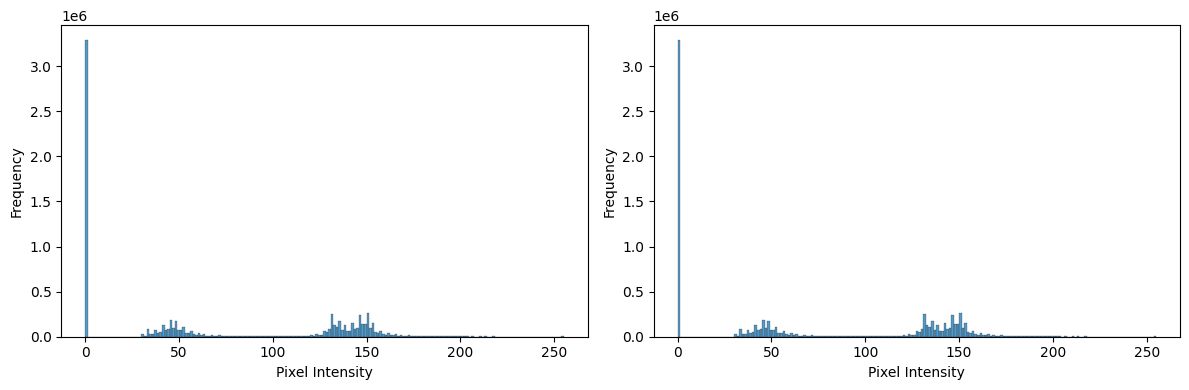

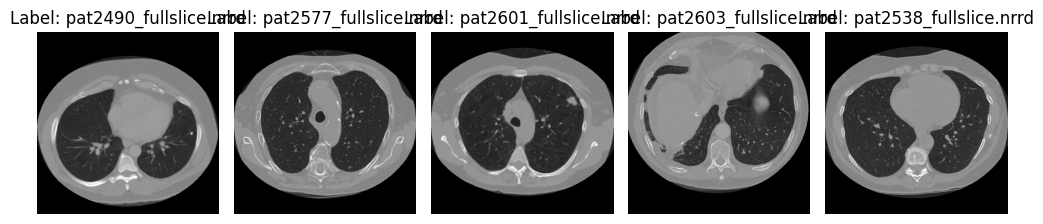

In [17]:
for image in train_dataset.take(1):
  print(image.shape)
  visualize_histograms(image.numpy(), image.numpy(), lim_x=False)
  visualize_images(image.numpy(), filenames)

### Median Filtering

In [18]:
import cv2

def median_filtering(data, filter_size=3):
    """
      Applica il filtro mediano utilizzando OpenCV. Compatibile con tf.py_function.
    """
    # Applicare il filtro mediano (assumendo immagine in scala di grigi / canale singolo)
    data = data.numpy()
    # Use OpenCV for batch processing
    filtered_data = np.empty_like(data)
    for i in range(data.shape[0]):
        filtered_data[i, ..., 0] = cv2.medianBlur(data[i, ..., 0].astype(np.uint8), filter_size)
    return filtered_data


In [19]:
def apply_median_filter(image):
    """
    Wrappa la funzione di median filtering con `tf.py_function` per lavorare con TensorFlow.
    """
    # Usare tf.py_function, che consente di utilizzare Python puro in tf.data pipelines
    filtered_image = tf.py_function(
        func=median_filtering,  # Funzione da chiamare
        inp=[image],  # Input alla funzione
        Tout=tf.uint8  # Tipo di output
    )
    filtered_image.set_shape(image.shape)  # Assicurare che l'output abbia la stessa forma dell'input

    # Restituire il tensore elaborato e le etichette originali
    return filtered_image


# Creare i dataset con il median filtering
train_dataset = train_dataset.map(apply_median_filter, num_parallel_calls=AUTOTUNE)

In [20]:
# for image,label in train_dataset.take(1):
#   print(image.shape)
#   print(label.shape)
#   visualize_histograms(image.numpy(), image.numpy(), lim_x=False)
#   visualize_images(image.numpy(), label.numpy())

### CLAHE

In [21]:
def clahe(data,
          clip_limit=3.0,
          tile_grid_size=(20,20)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to a batch of images.
    :param data: Numpy array of shape (n_batch, h, w, 1).
    :param clip_limit: Threshold for contrast limiting.
    :param tile_grid_size: Size of the grid for the CLAHE algorithm.
    :return: Images after applying CLAHE with the same shape as input.
    """
    # Create a CLAHE object
    data = data.numpy()
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    equalized_data = np.empty_like(data)

    for i in range(data.shape[0]):
        # Convert the image to uint8 if necessary
        #img_uint8 = cv2.normalize(data[i, ..., 0], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        # Apply CLAHE
        equalized_data[i, ..., 0] = clahe.apply(data[i, ..., 0].astype(np.uint8))

    return equalized_data


In [22]:
def apply_clahe(image):
    """
    Wrappa la funzione di median filtering con `tf.py_function` per lavorare con TensorFlow.
    """
    # Usare tf.py_function, che consente di utilizzare Python puro in tf.data pipelines
    filtered_image = tf.py_function(
        func=clahe,  # Funzione da chiamare
        inp=[image],  # Input alla funzione
        Tout=tf.uint8  # Tipo di output
    )
    filtered_image.set_shape(image.shape)  # Assicurare che l'output abbia la stessa forma dell'input

    # Restituire il tensore elaborato e le etichette originali
    return filtered_image



train_dataset = train_dataset.map(apply_clahe, num_parallel_calls=AUTOTUNE)

(32, 512, 512, 1)


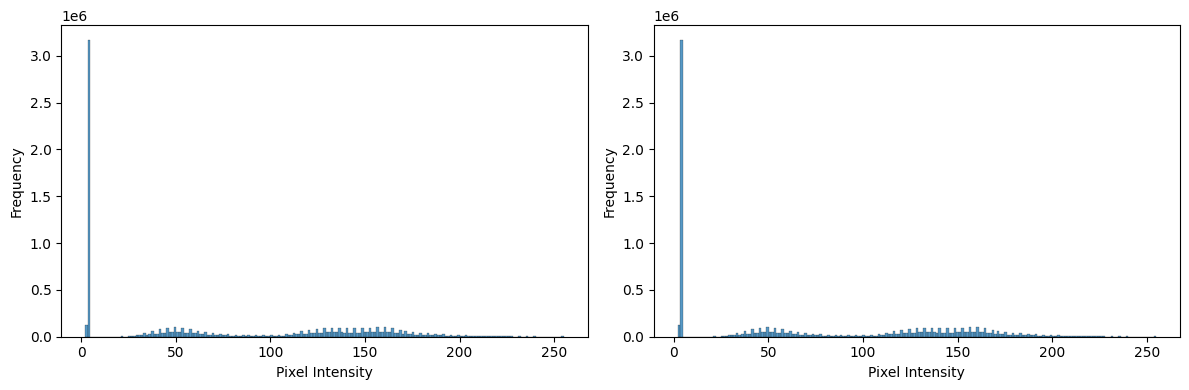

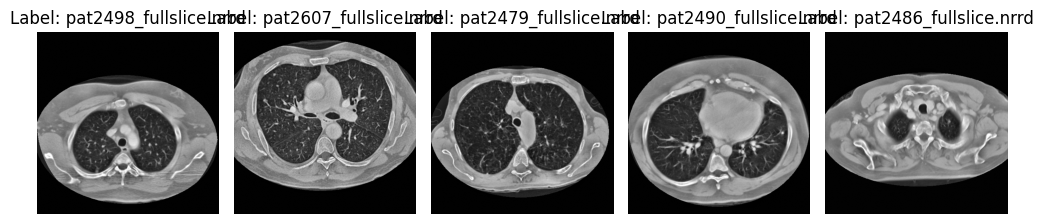

In [23]:
for image in train_dataset.take(1):
  print(image.shape)

  visualize_histograms(image.numpy(), image.numpy(), lim_x=False)
  visualize_images(image.numpy(), filenames)

### RGB conversion

In [24]:
def to_rgb(image):
    image = tf.image.grayscale_to_rgb(image)
    return image

train_dataset = train_dataset.map(to_rgb, num_parallel_calls=AUTOTUNE)


In [25]:
# Check shapes after transformations
for batch_images in train_dataset.take(1):
    print("Shape of training images batch:", batch_images.shape)


Shape of training images batch: (32, 512, 512, 3)


### Resizing

In [26]:
def resize_images(image):
  image = tf.image.resize(image, [224, 224])
  return image

train_dataset = train_dataset.map(resize_images, num_parallel_calls=AUTOTUNE)


In [27]:
# Check shapes after transformations
for batch_images in train_dataset.take(1):
    print("Shape of training images batch:", batch_images.shape)


Shape of training images batch: (32, 224, 224, 3)


## Directory handling for training

In [28]:
# change cwd for the training
training_dir = '/gdrive/My Drive/Applied AI in biomedicine/Group project/Training'
checkp_dir = 'last_training_checkpoints'
checkp_name = 'model_checkpoint.keras'


if os.path.isdir(training_dir):
    print(f"Directory '{training_dir}' exists and it's the cwd.")
    os.chdir(training_dir)
    checkp_dir = os.path.join(training_dir, checkp_dir)

    # Check if checkpoint dir exists
    if  os.path.isdir(checkp_dir):
      print(f"Directory '{checkp_dir}' exists.")

      # Create checkpoint filepath
      checkp_path = os.path.join(checkp_dir, checkp_name)
    else:
      raise Exception(f"Directory '{checkp_dir}' does not exist.")

else:
  raise Exception(f"Directory '{training_dir}' does not exist.")

os.getcwd()


Directory '/gdrive/My Drive/Applied AI in biomedicine/Group project/Training' exists and it's the cwd.
Directory '/gdrive/My Drive/Applied AI in biomedicine/Group project/Training/last_training_checkpoints' exists.


'/gdrive/.shortcut-targets-by-id/1oUZp9UH-_VPBCgQAfQTLtCF-qDnPMJ2P/Group project/Training'

## Evaluate results

In [29]:
# os.chdir('/gdrive/My Drive/Applied AI in biomedicine/Group project/Final_models')
# os.getcwd()

In [30]:
print(os.getcwd())
model_filename_2 = 'FM_final_40.52_model_convnext_tl_ft_20250205_1730.keras'
model = tfk.models.load_model(model_filename_2)

/gdrive/.shortcut-targets-by-id/1oUZp9UH-_VPBCgQAfQTLtCF-qDnPMJ2P/Group project/Training


In [31]:
y_test = model.predict(train_dataset)


9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


In [33]:
print(y_test)

y_test_argm = np.argmax(y_test, axis=1)
print(y_test_argm)

[[4.6702349e-03 4.3896232e-03 9.8463422e-01 2.1866481e-03 4.1192574e-03]
 [5.1274995e-04 8.2965918e-02 3.3682907e-01 5.7817906e-01 1.5131945e-03]
 [9.1047189e-04 4.0708869e-03 9.7873104e-01 1.5832949e-02 4.5458911e-04]
 ...
 [6.7487222e-06 9.9636841e-01 3.5612448e-03 4.7071662e-05 1.6516349e-05]
 [6.9424388e-04 5.4792535e-01 3.7707865e-01 8.3522545e-03 6.5949500e-02]
 [1.6323508e-04 5.3213700e-04 5.0944263e-01 7.3103327e-03 4.8255166e-01]]
[2 3 2 1 2 2 2 2 2 2 1 3 0 3 4 3 2 2 2 2 4 2 2 2 3 2 1 2 0 2 2 2 2 2 1 3 1
 1 2 2 2 2 3 0 3 2 2 4 2 3 2 4 2 2 2 2 2 2 2 0 2 1 2 2 3 2 2 0 2 0 2 2 3 2
 2 2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 0 3 2 2 2 2 0 2 3 2 1 2 2 2 2
 1 2 2 2 2 3 2 0 2 2 2 2 3 2 2 3 2 0 3 2 1 2 2 2 2 3 2 2 2 1 1 2 2 2 2 0 2
 1 2 2 2 3 2 2 3 2 1 2 2 3 2 2 2 2 3 2 2 2 2 2 2 3 2 0 2 2 2 3 2 2 1 3 2 1
 2 2 2 2 0 3 2 2 2 3 2 1 2 0 3 2 3 2 2 0 2 3 1 1 3 1 2 1 2 2 2 1 2 0 2 2 2
 1 2 0 1 2 2 3 4 3 2 2 2 2 2 2 2 2 3 2 2 2 2 1 3 3 1 2 1 2 2 2 2 3 0 2 4 2
 1 1 2]


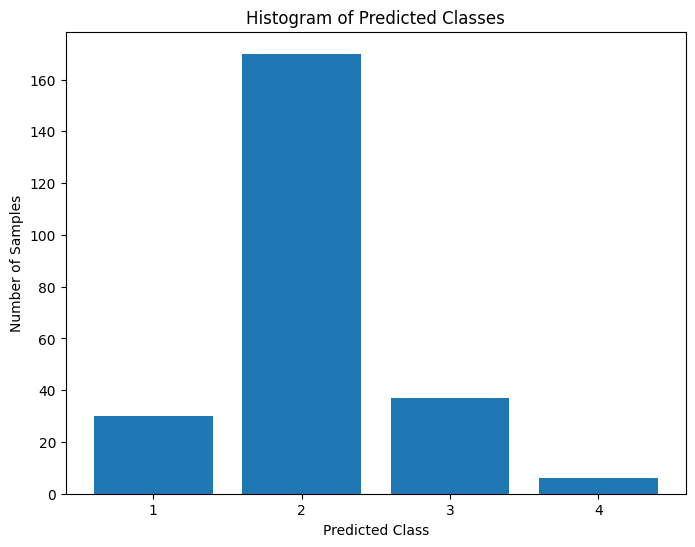

In [35]:
# prompt: histogram value counts of y_test_argm classes from 1 to 5

import matplotlib.pyplot as plt

# Assuming y_test_argm is defined as in your provided code
plt.hist(y_test_argm, bins=range(1, 7), align='left', rwidth=0.8) # bins from 1 to 6 (inclusive)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Classes")
plt.xticks(range(1, 6)) # xticks from 1 to 5
plt.show()


In [37]:
os.getcwd()
os.chdir('../Test_fullslice')
os.getcwd()

'/gdrive/.shortcut-targets-by-id/1oUZp9UH-_VPBCgQAfQTLtCF-qDnPMJ2P/Group project/Test_fullslice'

In [38]:
# Assuming y_test_rounded and filenames are already defined
# Save both y_test_rounded and filenames in a single .npy file
np.save('fullslice_test_predictions.npy', {'y_test_rounded': y_test_argm, 'filenames': filenames})
print("y_test_rounded and filenames saved to 'predictions_and_filenames.npy'")

y_test_rounded and filenames saved to 'predictions_and_filenames.npy'
